In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pythermalcomfort.models as pm
import pythermalcomfort.psychrometrics as pp

## Data import

In [388]:
df = pd.read_csv('CN_DB.csv')
print(df.columns)

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude',
       'age_group'],
      dtype='object')


In [389]:
df_city = pd.read_csv('CN_DB_CITY.csv')
df_city

,city,records,tsv,tcv,ta,ta_var,rh,vel,met,clo,top,tg,tr,t_out,latitude,tsr,tn_op,p_dh
0,HainanSanya,5,0.60,1.60,24.88,1.55,70.20,0.00,0.98,0.33,24.88,24.88,24.88,NaN,18.25,0.80,23.38,0.00
1,GuangdongGuangzhou,997,-0.01,1.38,23.85,1.16,52.94,0.10,1.00,0.86,23.88,23.88,23.90,16.71,23.13,0.90,23.91,0.00
2,YunnanKunming,415,-1.15,1.42,13.62,9.72,16.95,0.28,1.08,0.65,13.62,19.22,13.62,NaN,24.87,0.66,16.50,0.00
3,FujianFuzhou,7,-0.71,1.57,18.10,2.34,67.43,0.00,0.89,0.35,18.10,18.10,18.10,NaN,26.08,0.86,19.89,0.00
4,FujianZhenjiang,2,-0.50,1.50,22.90,5.12,74.50,0.00,0.90,0.31,22.90,22.90,22.90,NaN,26.10,0.50,24.15,0.00
5,FujianNanping,4,0.00,1.00,17.90,1.54,60.25,0.00,0.88,0.42,17.90,17.90,17.90,NaN,26.64,1.00,17.90,0.00
6,HunanHengyang,1,-1.00,2.00,16.90,NaN,66.00,0.00,0.90,0.66,16.90,16.90,16.90,NaN,26.89,1.00,19.40,0.00
7,HunanChangsha,1108,-0.40,2.82,17.22,10.75,48.35,0.03,1.02,0.95,17.41,18.20,17.59,NaN,28.23,0.89,18.40,0.00
8,SichuanZigong,23,-0.22,1.61,11.03,1.70,66.52,0.00,1.00,1.59,11.03,11.03,11.03,NaN,29.34,0.78,11.57,0.00
9,Lhasa,355,-1.10,NaN,10.64,16.26,71.19,0.02,1.10,1.25,10.64,10.64,10.64,NaN,29.65,0.64,13.38,0.01


Calcualte the distance of each city to Huai River (33˚N)

In [391]:
df_city['distance'] = df_city['latitude'] - 33

## Sharp Threshold Assumption
All cities have disctrict heating systems if the distance is >= 0</br>
No city has disctrict heating systems if the distance is < 0

In [392]:
# create a new dummy variable based on the distance
df_rd = df_city.assign(threshold=(df_city["distance"] > 0).astype(int))

## Effect of Policy (Z) on Thermal Conditions (X)
Difference between the treatment and control group near the Huai river, which can be viewed as the nature experiment outcome

### Air temp - Yes

In [362]:
model = smf.wls("ta~distance*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.6345,1.445,11.510,0.000,13.679,19.590
distance,-0.4087,0.274,-1.490,0.147,-0.970,0.152
threshold,4.6198,1.939,2.382,0.024,0.653,8.586
distance:threshold,0.5428,0.312,1.738,0.093,-0.096,1.182


The coef of the threshold is the causal effect, which is 4.6 ˚C, p-value is 0.02, and the 95% CI is [0.7, 8.6]

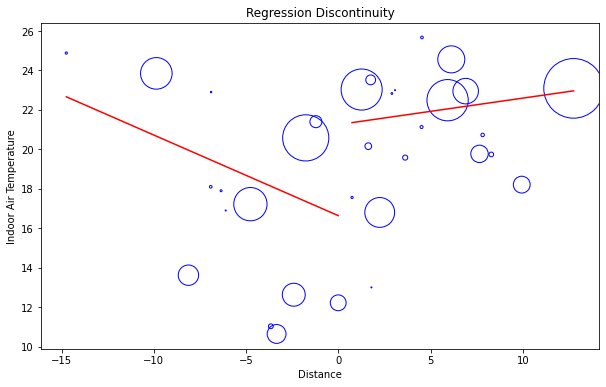

In [363]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['ta'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Indoor Air Temperature')
plt.title("Regression Discontinuity")
plt.show()


### Radiative Temperature - Yes
tg is the best, because it is directly measureed, and only has measurement error </br>
top, operative temperature, is calculated by ta and tr, so it has two measurement error and one calculation error

In [364]:
model = smf.wls("tr~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     4.4732
pvalue is:  0.025


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.8295,1.413,11.914,0.000,13.941,19.719
distance,-0.4013,0.268,-1.497,0.145,-0.950,0.147
threshold,4.4732,1.896,2.360,0.025,0.596,8.350
distance:threshold,0.4992,0.305,1.635,0.113,-0.125,1.123


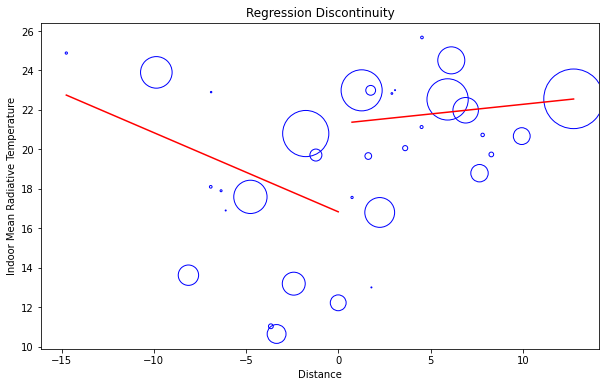

In [365]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['tr'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Indoor Mean Radiative Temperature')
plt.title("Regression Discontinuity")
plt.show()

### Operative Temperature - Yes

In [366]:
model = smf.wls("top~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     4.4055
pvalue is:  0.030


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.8379,1.434,11.742,0.000,13.905,19.771
distance,-0.3928,0.272,-1.443,0.160,-0.949,0.164
threshold,4.4055,1.924,2.289,0.030,0.470,8.341
distance:threshold,0.5018,0.310,1.619,0.116,-0.132,1.136


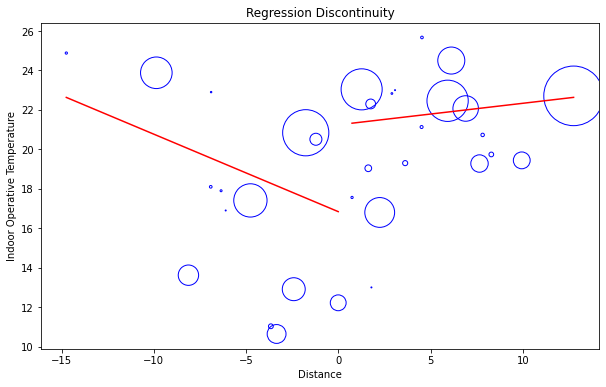

In [367]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['top'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Indoor Operative Temperature')
plt.title("Regression Discontinuity")
plt.show()

### Air temperature variance - Yes

In [396]:
model = smf.wls("ta_var~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:    -9.6303
pvalue is:  0.000


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,20.0832,1.688,11.895,0.000,16.613,23.554
distance,1.7734,0.320,5.535,0.000,1.115,2.432
threshold,-9.6303,2.266,-4.250,0.000,-14.288,-4.973
distance:threshold,-2.1395,0.365,-5.864,0.000,-2.889,-1.390


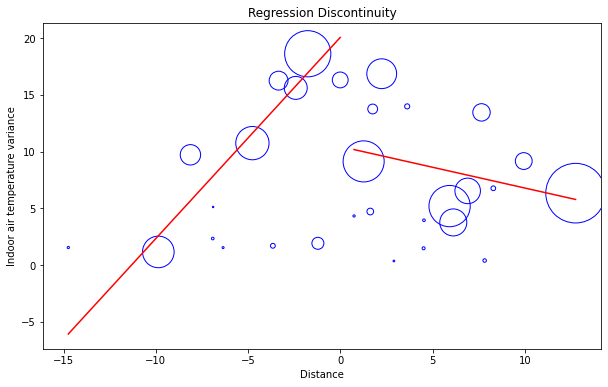

In [400]:
plt.figure(figsize=(10, 6))
# remove nanvalues of ta_var in df_rd
df_rd = df_rd.dropna(subset=['ta_var'])
plt.scatter(df_rd['distance'], df_rd['ta_var'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Indoor air temperature variance')
plt.title("Regression Discontinuity")
plt.show()

### Relative Humdity - Yes

In [368]:
model = smf.wls("rh~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:   -23.7879
pvalue is:  0.000


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,55.0729,4.302,12.801,0.000,46.274,63.872
distance,1.1155,0.816,1.366,0.182,-0.554,2.785
threshold,-23.7879,5.773,-4.120,0.000,-35.595,-11.980
distance:threshold,-0.9500,0.930,-1.022,0.315,-2.851,0.951


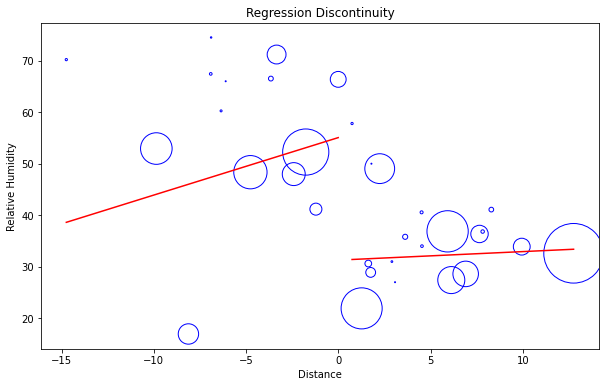

In [369]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['rh'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Relative Humidity')
plt.title("Regression Discontinuity")
plt.show()

### Wet-bulb Temp - No

In [370]:
# calculate the wet bulb globe temperature for each city using pp.t_wb()
df_rd['t_wb'] = df_rd.apply(lambda x: pp.t_wb(tdb=x['ta'], rh=x['rh']), axis=1)

In [371]:
model = smf.wls("t_wb~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.3177
pvalue is:  0.850


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.3475,1.239,9.156,0.000,8.813,13.882
distance,-0.2283,0.235,-0.971,0.340,-0.709,0.253
threshold,0.3177,1.663,0.191,0.850,-3.084,3.719
distance:threshold,0.3848,0.268,1.437,0.161,-0.163,0.933


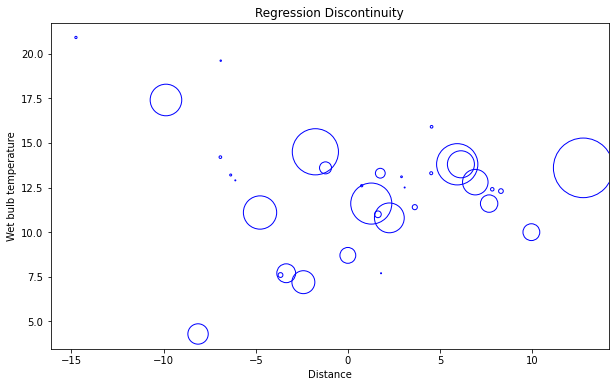

In [372]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['t_wb'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Wet bulb temperature')
plt.title("Regression Discontinuity")
plt.show()

### Air Velocity - No

In [373]:
model = smf.wls("vel~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.0160
pvalue is:  0.511


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0063,0.018,0.353,0.727,-0.030,0.043
distance,-0.0132,0.003,-3.866,0.001,-0.020,-0.006
threshold,0.0160,0.024,0.666,0.511,-0.033,0.065
distance:threshold,0.0143,0.004,3.687,0.001,0.006,0.022


### Metabolic Rate - No

In [374]:
model = smf.wls("met~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.0289
pvalue is:  0.372


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0919,0.024,46.054,0.000,1.043,1.140
distance,0.0082,0.004,1.823,0.079,-0.001,0.017
threshold,0.0289,0.032,0.907,0.372,-0.036,0.094
distance:threshold,-0.0168,0.005,-3.276,0.003,-0.027,-0.006


### Clothing Insulation - No

In [375]:
model = smf.wls("clo~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:    -0.2748
pvalue is:  0.087


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1598,0.115,10.048,0.000,0.924,1.396
distance,0.0357,0.022,1.628,0.114,-0.009,0.080
threshold,-0.2748,0.155,-1.774,0.087,-0.592,0.042
distance:threshold,-0.0317,0.025,-1.272,0.214,-0.083,0.019


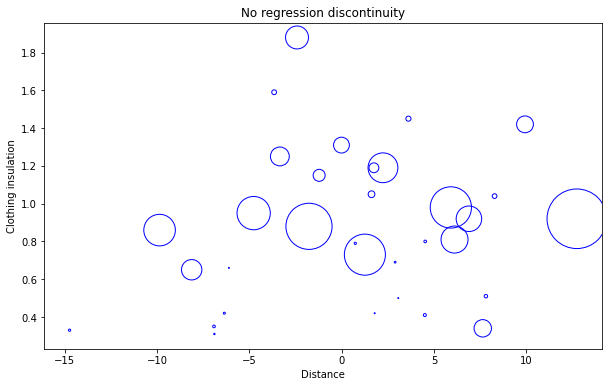

In [376]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['clo'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Clothing insulation')
plt.title("No regression discontinuity")

plt.show()

Conclusion: the policy doesn't have a statistically significant effect on clothing insulations </br>
Assuming that the policy affects clothing insulation only through indoor thermal environment, represented by tg </br>
Then, increasing indoor temperature from 17 to 22 (5 delta) doesn't affect clothing insulation in the population </br>

### Thermal Sensation Vote - Yes

In [377]:
model = smf.wls("tsv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.6311
pvalue is:  0.016


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3995,0.184,-2.174,0.038,-0.775,-0.024
distance,-0.0032,0.035,-0.092,0.928,-0.075,0.068
threshold,0.6311,0.247,2.559,0.016,0.127,1.136
distance:threshold,0.0036,0.040,0.090,0.929,-0.078,0.085


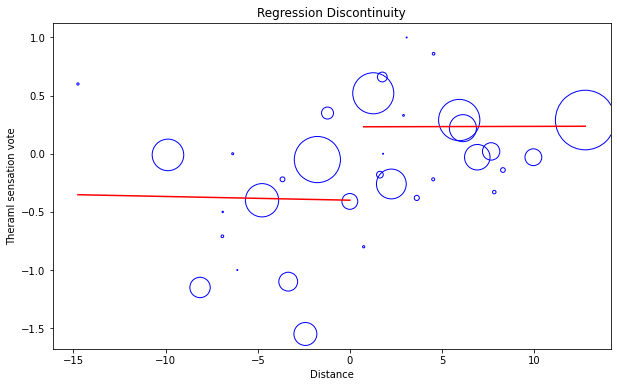

In [378]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['tsv'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Theraml sensation vote')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy affects thermal sensations only through indoor thermal environment, represented by tg </br>
Which means there is no psychological effect </br>
Then, then increasing indoor temperature from 17 to 22 (5 delta) would increase thermal sensation from -0.4 to 0.2 (0.6 delta) </br>
This is half less than the predicted changes of thermal sensations votes using PMV model

### Thermal Comfort Vote - No

In [379]:
model = smf.wls("tcv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:    -0.2209
pvalue is:  0.394


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6973,0.197,8.616,0.000,1.293,2.101
distance,-0.0036,0.036,-0.100,0.921,-0.077,0.070
threshold,-0.2209,0.255,-0.867,0.394,-0.744,0.302
distance:threshold,0.0103,0.040,0.255,0.801,-0.073,0.093


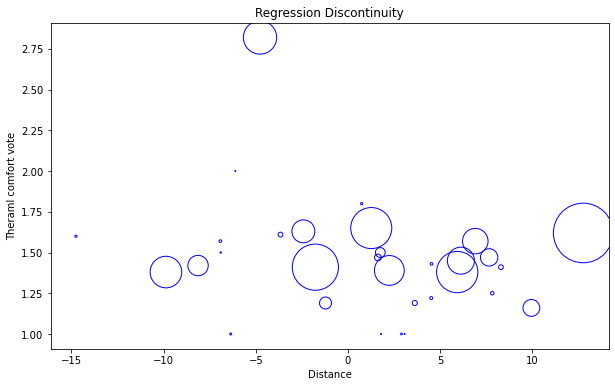

In [380]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['tcv'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Theraml comfort vote')
plt.title("Regression Discontinuity")
plt.show()

### Thermal Satisfaction Rate - No

In [381]:
model = smf.wls("tsr~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:     0.0383


pvalue is:  0.580


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8158,0.051,16.035,0.000,0.712,0.920
distance,-0.0029,0.010,-0.296,0.769,-0.023,0.017
threshold,0.0383,0.068,0.560,0.580,-0.101,0.178
distance:threshold,0.0018,0.011,0.162,0.873,-0.021,0.024


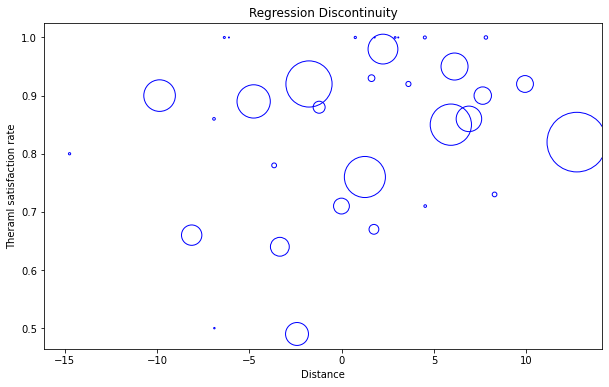

In [382]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['tsr'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Theraml satisfaction rate')
plt.title("Regression Discontinuity")
plt.show()

## Effect of P on Neutral Temperature (tricky)


In [383]:
# needs one more non-NaN neutral temperature/comfort zone calcualted by regression approach a and b
# neutral temperature calcualted by Griffth method, and using measured globe temperature
model = smf.wls("tn_op~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Causal effect is:", model.summary().tables[1][3][1])
print("p-value is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Causal effect is:     2.8191
p-value is:  0.057


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.8377,1.058,16.857,0.000,15.674,20.002
distance,-0.3848,0.201,-1.916,0.065,-0.795,0.026
threshold,2.8191,1.420,1.985,0.057,-0.085,5.723
distance:threshold,0.4924,0.229,2.154,0.040,0.025,0.960


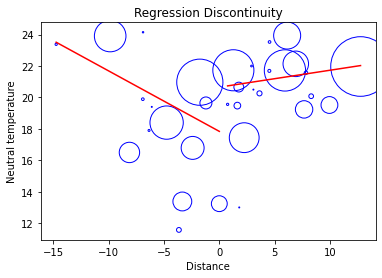

In [384]:
# scatter plot tn_op vs distance
plt.scatter(df_rd['distance'], df_rd['tn_op'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Neutral temperature')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy can only affect the neutral temperature through indoor thermal enviornment, represented by the tg. Then the causal effect of indoor globe temperature on neutral temperature is 4.6279/5.2973 = 0.87 (95% CI:0.64, 0.92)

## Effect of X on Comfort Vote
The assumption is that the district heating policy affects Y only through indoor thermal environment, represented by  </br>

P -> X -> Y

## Fuzzy Threshold Assumption
All cities have disctrict heating systems if the distance is > 2
No city has disctrict heating systems if the distance is < -2